**Predicting Price with Size, Location, and Neighborhood**

In \[2\]:

    import warnings
    from glob import glob

    import pandas as pd
    import seaborn as sns
    import wqet_grader
    from category_encoders import OneHotEncoder
    from IPython.display import VimeoVideo
    from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
    from sklearn.impute import SimpleImputer
    from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
    from sklearn.metrics import mean_absolute_error
    from sklearn.pipeline import make_pipeline
    from sklearn.utils.validation import check_is_fitted

    warnings.simplefilter(action="ignore", category=FutureWarning)
    wqet_grader.init("Project 2 Assessment")

In the final lesson for this project, we're going to try to use all the
features in our dataset to improve our model. This means that we'll have
to do a more careful cleaning of the dataset and consider some of the
finer points of linear models.

In \[3\]:

    VimeoVideo("656842813", h="07f074324e", width=600)

Out\[3\]:

[](https://vimeo.com/656842813)

Play



# Prepare Data<a href="#Prepare-Data" class="anchor-link">¶</a>

## Import<a href="#Import" class="anchor-link">¶</a>

In \[4\]:

    def wrangle(filepath):
        # Read CSV file
        df = pd.read_csv(filepath)

        # Subset data: Apartments in "Capital Federal", less than 400,000
        mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
        mask_apt = df["property_type"] == "apartment"
        mask_price = df["price_aprox_usd"] < 400_000
        df = df[mask_ba & mask_apt & mask_price]

        # Subset data: Remove outliers for "surface_covered_in_m2"
        low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
        mask_area = df["surface_covered_in_m2"].between(low, high)
        df = df[mask_area]

        # Split "lat-lon" column
        df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
        df.drop(columns="lat-lon", inplace=True)

        # Get place name
        df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
        df.drop(columns="place_with_parent_names", inplace=True)
        
        #remove the columns which are maximum null counts
        df.drop(columns=["floor", "expenses"], inplace=True)
        
        #remove low and high cardinality categorical variable
        df.drop(columns=["operation","property_type","currency","properati_url"], inplace=True)
        
        #remove licky columns
        df.drop(columns=[
             'price',
             'price_aprox_local_currency',
             'price_per_m2',
             'price_usd_per_m2'

        ], 
                inplace=True)
        
        #remove columns with multicollinearity
        df.drop(columns=["rooms", "surface_total_in_m2"], inplace=True)

        
        return df

Let's begin by using what we've learned to load all our CSV files into a
DataFrame.

In \[5\]:

    VimeoVideo("656842538", h="bd85634eb1", width=600)

Out\[5\]:

[](https://vimeo.com/656842538)

Play



**Task 2.4.1:** Use
[`glob`](https://docs.python.org/3/library/glob.html#glob.glob) to
create a list that contains the filenames for all the Buenos Aires real
estate CSV files in the `data` directory. Assign this list to the
variable name `files`.

-   Assemble a list of path names that match a pattern in
    glob.

In \[6\]:

    files = glob("data/buenos-aires-real-estate-*.csv")
    files

Out\[6\]:

    ['data/buenos-aires-real-estate-2.csv',
     'data/buenos-aires-real-estate-4.csv',
     'data/buenos-aires-real-estate-3.csv',
     'data/buenos-aires-real-estate-1.csv',
     'data/buenos-aires-real-estate-5.csv']

In \[7\]:

    # Check your work
    assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

The last time we put all our DataFrames into a list, we used a `for`
loop. This time, we're going to use a more compact coding technique
called a **list comprehension**.

In \[8\]:

    VimeoVideo("656842076", h="0f654d427f", width=600)

Out\[8\]:

[](https://vimeo.com/656842076)

Play



**Task 2.4.2:** Use your `wrangle` function in a list comprehension to
create a list named `frames`. The list should contain the cleaned
DataFrames for the filenames your collected in `files`.

-   [What's a <span id="term">list
    comprehension</span>?](../%40textbook/02-python-advanced.ipynb#List-Comprehension-)
-   Write a list comprehension in
    Python

In \[9\]:

    frames = [wrangle(file) for file in files]
    df = pd.concat(frames, ignore_index=True)
    print(df.info())
    df.head()
    #type(frames[0])
    #frames[0].info()
    #frames[0].shape
    #frames[0].head() 

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 6582 entries, 0 to 6581
    Data columns (total 5 columns):
     #   Column                 Non-Null Count  Dtype  
    ---  ------                 --------------  -----  
     0   price_aprox_usd        6582 non-null   float64
     1   surface_covered_in_m2  6582 non-null   float64
     2   lat                    6316 non-null   float64
     3   lon                    6316 non-null   float64
     4   neighborhood           6582 non-null   object 
    dtypes: float64(4), object(1)
    memory usage: 257.2+ KB
    None

Out\[9\]:

|     | price_aprox_usd | surface_covered_in_m2 | lat        | lon        | neighborhood     |
|-----|-----------------|-----------------------|------------|------------|------------------|
| 0   | 215000.00       | 35.0                  | -34.588993 | -58.400133 | Recoleta         |
| 1   | 341550.00       | 90.0                  | -34.588044 | -58.398066 | Recoleta         |
| 2   | 91156.62        | 33.0                  | -34.623320 | -58.397461 | Monserrat        |
| 3   | 105000.00       | 33.0                  | -34.553897 | -58.451939 | Belgrano         |
| 4   | 89681.00        | 39.0                  | -34.628813 | -58.472230 | Villa del Parque |

In \[10\]:

    # Check your work
    assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
    assert all(
        [isinstance(frame, pd.DataFrame) for frame in frames]
    ), "The items in `frames` should all be DataFrames."

Last step: Combine the DataFrames in `frames` into a single `df`.

In \[11\]:

    VimeoVideo("656841910", h="79c7dbc5ab", width=600)

Out\[11\]:

[](https://vimeo.com/656841910)

Play



**Task 2.4.3:** Use
[`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)
to concatenate it items in `frames` into a single DataFrame `df`. Make
sure you set the `ignore_index` argument to `True`.

-   Concatenate two or more DataFrames using
    pandas.

In \[ \]:

     

In \[12\]:

    # Check your work
    assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
    assert df.shape[1] <= 17, f"`df` has too many columns: {df.shape[1]}"

## Explore<a href="#Explore" class="anchor-link">¶</a>

The first thing we need to consider when trying to use all the features
`df` is **missing values**. While it's true you can impute missing
values, there still needs to be enough data in a column to do a good
imputation. A general rule is that, if more than half of the data in a
column is missing, it's better to drop it then try imputing.

Take a look at the output from `df.info()` above. Are there columns
where more than half of the values are `NaN`? If so, those columns need
to go!

In \[13\]:

    VimeoVideo("656848648", h="6964fa0c8c", width=600)

Out\[13\]:

[](https://vimeo.com/656848648)

Play



In \[14\]:

    #df.isnull().head()
    #df.isnull().sum() 
    df.isnull().sum() / len(df)

Out\[14\]:

    price_aprox_usd          0.000000
    surface_covered_in_m2    0.000000
    lat                      0.040413
    lon                      0.040413
    neighborhood             0.000000
    dtype: float64

**Task 2.4.4:** Modify your `wrangle` function to drop any columns that
are more than half `NaN` values. Be sure to rerun all the cells above
before you continue.

-   Inspect a DataFrame using the `shape`, `info`, and `head` in
    pandas.
-   Drop a column from a DataFrame using
    pandas.

In \[15\]:

    # Check your work
    assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
    assert df.shape[1] <= 15, f"`df` has too many columns: {df.shape[1]}"

The next thing we need to look out for are categorical columns with
**low or high cardinality**. If there's only one category in a column,
it won't provide any unique information to our model. At the other
extreme, columns where nearly every row has its own category won't help
our model in identifying useful trends in the data.

Let's take a look at the cardinality of our features.

In \[16\]:

    VimeoVideo("656848196", h="37dbc44b09", width=600)

Out\[16\]:

[](https://vimeo.com/656848196)

Play



**Task 2.4.5:** Calculate the number of unique values for each
non-numeric feature in `df`.

-   Subset a DataFrame's columns based on the column data types in
    pandas.
-   Calculate summary statistics for a DataFrame or Series in
    pandas.

In \[17\]:

    #df.select_dtypes("object").head()
    df.select_dtypes("object").nunique() #to see low and high cardinal categorical features

Out\[17\]:

    neighborhood    57
    dtype: int64

Here, we can see that columns like `"operation"` have only one value in
them, while every row in `"properati_url"` has a unique value. These are
clear examples of high- and low-cardinality features that we shouldn't
include in our model.

**Task 2.4.6:** Modify your `wrangle` function to drop high- and
low-cardinality categorical features.

Be sure to rerun all the cells above before you continue.

-   What are
    high- and low-cardinality features?
-   Drop a column from a DataFrame using
    pandas.

In \[18\]:

    # Check your work
    assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
    assert df.shape[1] <= 11, f"`df` has too many columns: {df.shape[1]}"

It's also important for us to drop any columns that would constitute
**leakage**, that is, features that were created using our target or
that would give our model information that it won't have access to when
it's deployed.

In \[19\]:

    VimeoVideo("656847896", h="11de775937", width=600)

Out\[19\]:

[](https://vimeo.com/656847896)

Play



In \[20\]:

    sorted(df.columns)

Out\[20\]:

    ['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

**Task 2.4.7:** Modify your `wrangle` function to drop any features that
would constitute leakage.

Be sure to rerun all the cells above before you continue.

-   What's
    leakage?
-   Drop a column from a DataFrame using
    pandas.

In \[21\]:

    # Check your work
    assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
    assert df.shape[1] <= 7, f"`df` has too many columns: {df.shape[1]}"

Finally, the last issue we need to keep an eye out for is
**multicollinearity**, that is, features in our feature matrix that are
highly correlated with each other. A good way to detect this is to use a
heatmap. Let's make one!

In \[22\]:

    VimeoVideo("656847237", h="4b5cfed5d6", width=600)

Out\[22\]:

[](https://vimeo.com/656847237)

Play



**Task 2.4.8:** Plot a correlation heatmap of the remaining numerical
features in `df`. Since `"price_aprox_usd"` will be your target, you
don't need to include it in your heatmap.

-   What's a
    heatmap?
-   Create a correlation matrix in
    pandas.
-   Create a heatmap in
    seaborn.

In \[23\]:

    corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
    sns.heatmap(corr)

Out\[23\]:

    <AxesSubplot:>

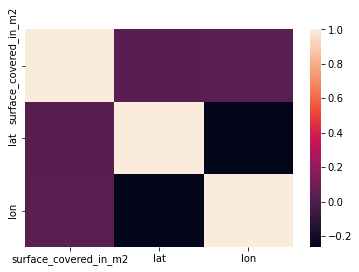

In \[24\]:

    df.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 6582 entries, 0 to 6581
    Data columns (total 5 columns):
     #   Column                 Non-Null Count  Dtype  
    ---  ------                 --------------  -----  
     0   price_aprox_usd        6582 non-null   float64
     1   surface_covered_in_m2  6582 non-null   float64
     2   lat                    6316 non-null   float64
     3   lon                    6316 non-null   float64
     4   neighborhood           6582 non-null   object 
    dtypes: float64(4), object(1)
    memory usage: 257.2+ KB

**Task 2.4.9:** Modify your `wrangle` function to remove columns so that
there are no strongly correlated features in your feature matrix.

Be sure to rerun all the cells above before you continue.

-   What's
    multicollinearity?
-   Drop a column from a DataFrame using
    pandas.

In \[25\]:

    # Check your work
    assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
    assert df.shape[1] == 5, f"`df` has the wrong number of columns: {df.shape[1]}"
    df.head()
    df.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 6582 entries, 0 to 6581
    Data columns (total 5 columns):
     #   Column                 Non-Null Count  Dtype  
    ---  ------                 --------------  -----  
     0   price_aprox_usd        6582 non-null   float64
     1   surface_covered_in_m2  6582 non-null   float64
     2   lat                    6316 non-null   float64
     3   lon                    6316 non-null   float64
     4   neighborhood           6582 non-null   object 
    dtypes: float64(4), object(1)
    memory usage: 257.2+ KB

Done! It looks like we're going to use the four features we've used in
our previous models but, this time, we're going to combine them.

## Split Data<a href="#Split-Data" class="anchor-link">¶</a>

**Task 2.4.10:** Create your feature matrix `X_train` and target vector
`y_train`. Your target is `"price_aprox_usd"`. Your features should be
all the columns that remain in the DataFrame you cleaned above.

-   What's a
    feature matrix?
-   What's a
    target vector?
-   Subset a DataFrame by selecting one or more columns in
    pandas.
-   Select a Series from a DataFrame in
    pandas.

In \[26\]:

    features = ["surface_covered_in_m2","lat", "lon","neighborhood"]
    X_train = df[features]
    #X_train.head()
    target = "price_aprox_usd"
    y_train = df[target]

In \[27\]:

    # Check your work
    assert X_train.shape == (6582, 4), f"`X_train` is the wrong size: {X_train.shape}."
    assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

# Build Model<a href="#Build-Model" class="anchor-link">¶</a>

## Baseline<a href="#Baseline" class="anchor-link">¶</a>

In \[28\]:

    VimeoVideo("656849559", h="bca444c8af", width=600)

Out\[28\]:

[](https://vimeo.com/656849559)

Play



**Task 2.4.11:** Calculate the baseline mean absolute error for your
model.

-   Calculate summary statistics for a DataFrame or Series in
    pandas.

In \[29\]:

    y_mean = y_train.mean()
    y_pred_baseline = [y_mean] * len(y_train)
    print("Mean apt price:", round(y_mean, 2))

    print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

    Mean apt price: 132383.84
    Baseline MAE: 44860.10834274133

## Iterate<a href="#Iterate" class="anchor-link">¶</a>

**Task 2.4.12:** Create a pipeline named `model` that contains a
`OneHotEncoder`, `SimpleImputer`, and `Ridge` predictor.

-   What's
    imputation?
-   What's
    one-hot encoding?
-   What's a
    pipeline?
-   Create a pipeline in
    scikit-learn.

In \[30\]:

    #create model

    model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        Ridge()
    )
    #fit model
    model.fit(X_train, y_train)

Out\[30\]:

    Pipeline(steps=[('onehotencoder',
                     OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                    ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In \[31\]:

    # Check your work
    check_is_fitted(model[-1])

## Evaluate<a href="#Evaluate" class="anchor-link">¶</a>

In \[32\]:

    VimeoVideo("656849505", h="f153a4f005", width=600)

Out\[32\]:

[](https://vimeo.com/656849505)

Play



**Task 2.4.13:** Calculate the training mean absolute error for your
predictions as compared to the true targets in `y_train`.

-   Generate predictions using a trained model in
    scikit-learn.
-   Calculate the mean absolute error for a list of predictions in
    scikit-learn.

In \[34\]:

    y_pred_training = model.predict(X_train)
    print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

    Training MAE: 24207.1071903302

**Task 2.4.14:** Run the code below to import your test data
`buenos-aires-test-features.csv` into a DataFrame and generate a list of
predictions using your model. Then run the following cell to submit your
predictions to the grader.

-   [What's
    generalizability?](../%40textbook/12-ml-core.ipynb#Generalization)
-   Generate predictions using a trained model in
    scikit-learn.
-   Calculate the mean absolute error for a list of predictions in
    scikit-learn.

In \[35\]:

    X_test = pd.read_csv("data/buenos-aires-test-features.csv")
    y_pred_test = pd.Series(model.predict(X_test))
    y_pred_test.head()

Out\[35\]:

    0    231122.403569
    1    162572.942392
    2     68477.949626
    3     63521.438989
    4    105694.463885
    dtype: float64

In \[36\]:

    wqet_grader.grade("Project 2 Assessment", "Task 2.4.14", y_pred_test)



Your model's mean absolute error is `26156.535`. Wow, you're making
great progress.

Score: 1

# Communicate Results<a href="#Communicate-Results" class="anchor-link">¶</a>

For this lesson, we've relied on equations and visualizations for
communication about our model. In many data science projects, however,
communication means giving stakeholders tools they can use to **deploy**
a model — in other words, use it in action. So let's look at two ways
you might deploy this model.

One thing you might be asked to do it wrap your model in a function so
that a programmer can provide inputs and then receive a prediction as
output.

In \[37\]:

    VimeoVideo("656849254", h="e6faad47ca", width=600)

Out\[37\]:

[](https://vimeo.com/656849254)

Play



**Task 2.4.15:** Create a function `make_prediction` that takes four
arguments (`area`, `lat`, `lon`, and `neighborhood`) and returns your
model's prediction for an apartment price.

In \[59\]:

    def make_prediction(area, lat, lon, neighborhood):
        data = {
            "surface_covered_in_m2": area,
            "lat": lat,
            "lon": lon,
            "neighborhood": neighborhood
        }
        df = pd.DataFrame(data, index=[0]).round(2)
        prediction = model.predict(df)
        return f"Predicted apartment price: ${prediction}"

Let's see if your function works. Run the cell below to find out!

In \[60\]:

    make_prediction(110, -34.60, -58.46, "Villa Crespo")

Out\[60\]:

    'Predicted apartment price: $[250775.11270376]'

Another type of deployment is creating and interactive dashboard, where
a user can supply values and receive a prediction. Let's create one
using [Jupyter
Widgets](https://ipywidgets.readthedocs.io/en/latest/index.html).

In \[61\]:

    VimeoVideo("656848911", h="7939dcd479", width=600)

Out\[61\]:

[](https://vimeo.com/656848911)

Play



**Task 2.4.16:** Add your `make_prediction` to the interact widget
below, run the cell, and then adjust the widget to see how predicted
apartment price changes.

-   Create an interact function in Jupyter Widgets.

In \[62\]:

    interact(
        make_prediction,
        area=IntSlider(
            min=X_train["surface_covered_in_m2"].min(),
            max=X_train["surface_covered_in_m2"].max(),
            value=X_train["surface_covered_in_m2"].mean(),
        ),
        lat=FloatSlider(
            min=X_train["lat"].min(),
            max=X_train["lat"].max(),
            step=0.01,
            value=X_train["lat"].mean(),
        ),
        lon=FloatSlider(
            min=X_train["lon"].min(),
            max=X_train["lon"].max(),
            step=0.01,
            value=X_train["lon"].mean(),
        ),
        neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
    );

Great work! You may have noticed that there a lots of ways to improve
this dashboard. For instance, a user can select a neighborhood and then
supply latitude-longitude coordinates that aren't in that neighborhood.
It would also be helpful to include a visualization like a map.
Regardless, this is a great first step towards creating dynamic
dashboards that turn your model from a complicated abstraction to a
concrete tool that anyone can access. One of the most important parts of
data science projects is creating products that people can use to make
their work or lives easier.

------------------------------------------------------------------------

Copyright © 2022 WorldQuant University. This content is licensed solely
for personal use. Redistribution or publication of this material is
strictly prohibited.